# Resolution and Domain Figures for Model Development chapter

* Domains
  * Example of full UK domain at 2.2km
  * Example of London 64x64 at 2.2km
  * Example of Bham 64x64 at 2.2km
  * Example of Bham 64x64 at 8.8km
* Effective Resolution
  * PSD of 2.2km and 8.8km

In [ ]:
%reload_ext autoreload

%autoreload 2

%reload_ext dotenv
%dotenv
    
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import string
import xarray as xr

from mlde_utils import VariableMetadata, cp_model_rotated_pole
from mlde_utils.data.coarsen import Coarsen
from mlde_utils.data.select_domain import SelectDomain
from mlde_utils.data.sum import Sum

from mlde_analysis import plot_map
from mlde_analysis.data import si_to_mmday

In [ ]:
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
ensemble_member="01"
ds = xr.merge(
    xr.open_dataset(VariableMetadata(Path(os.getenv("DERIVED_DATA"), "moose"), variable=var, frequency="day", domain="uk", resolution="2.2km", ensemble_member=ensemble_member, scenario="rcp85").filepath(2080)).isel(time=1) for var in ["lssnow", "lsrain"]
).rename({"stratiform_snowfall_flux": "lssnow", "stratiform_rainfall_flux": "lsrain"})
ds = Sum(variables=["lssnow", "lsrain"], new_variable="pr").run(ds)
ds["pr"] = ds["pr"].assign_attrs({"units": "kg m-2 s-1", "standard_name": "precipitation_flux", "grid_mapping": "rotated_latitude_longitude"})
ds["pr"] = si_to_mmday(ds["pr"])
# ds = ds.isel(time=1)
ds4x, ds = Coarsen(4).run(ds)
print(f"{ensemble_member} {ds.time.values}")

01 2079-12-02 12:00:00


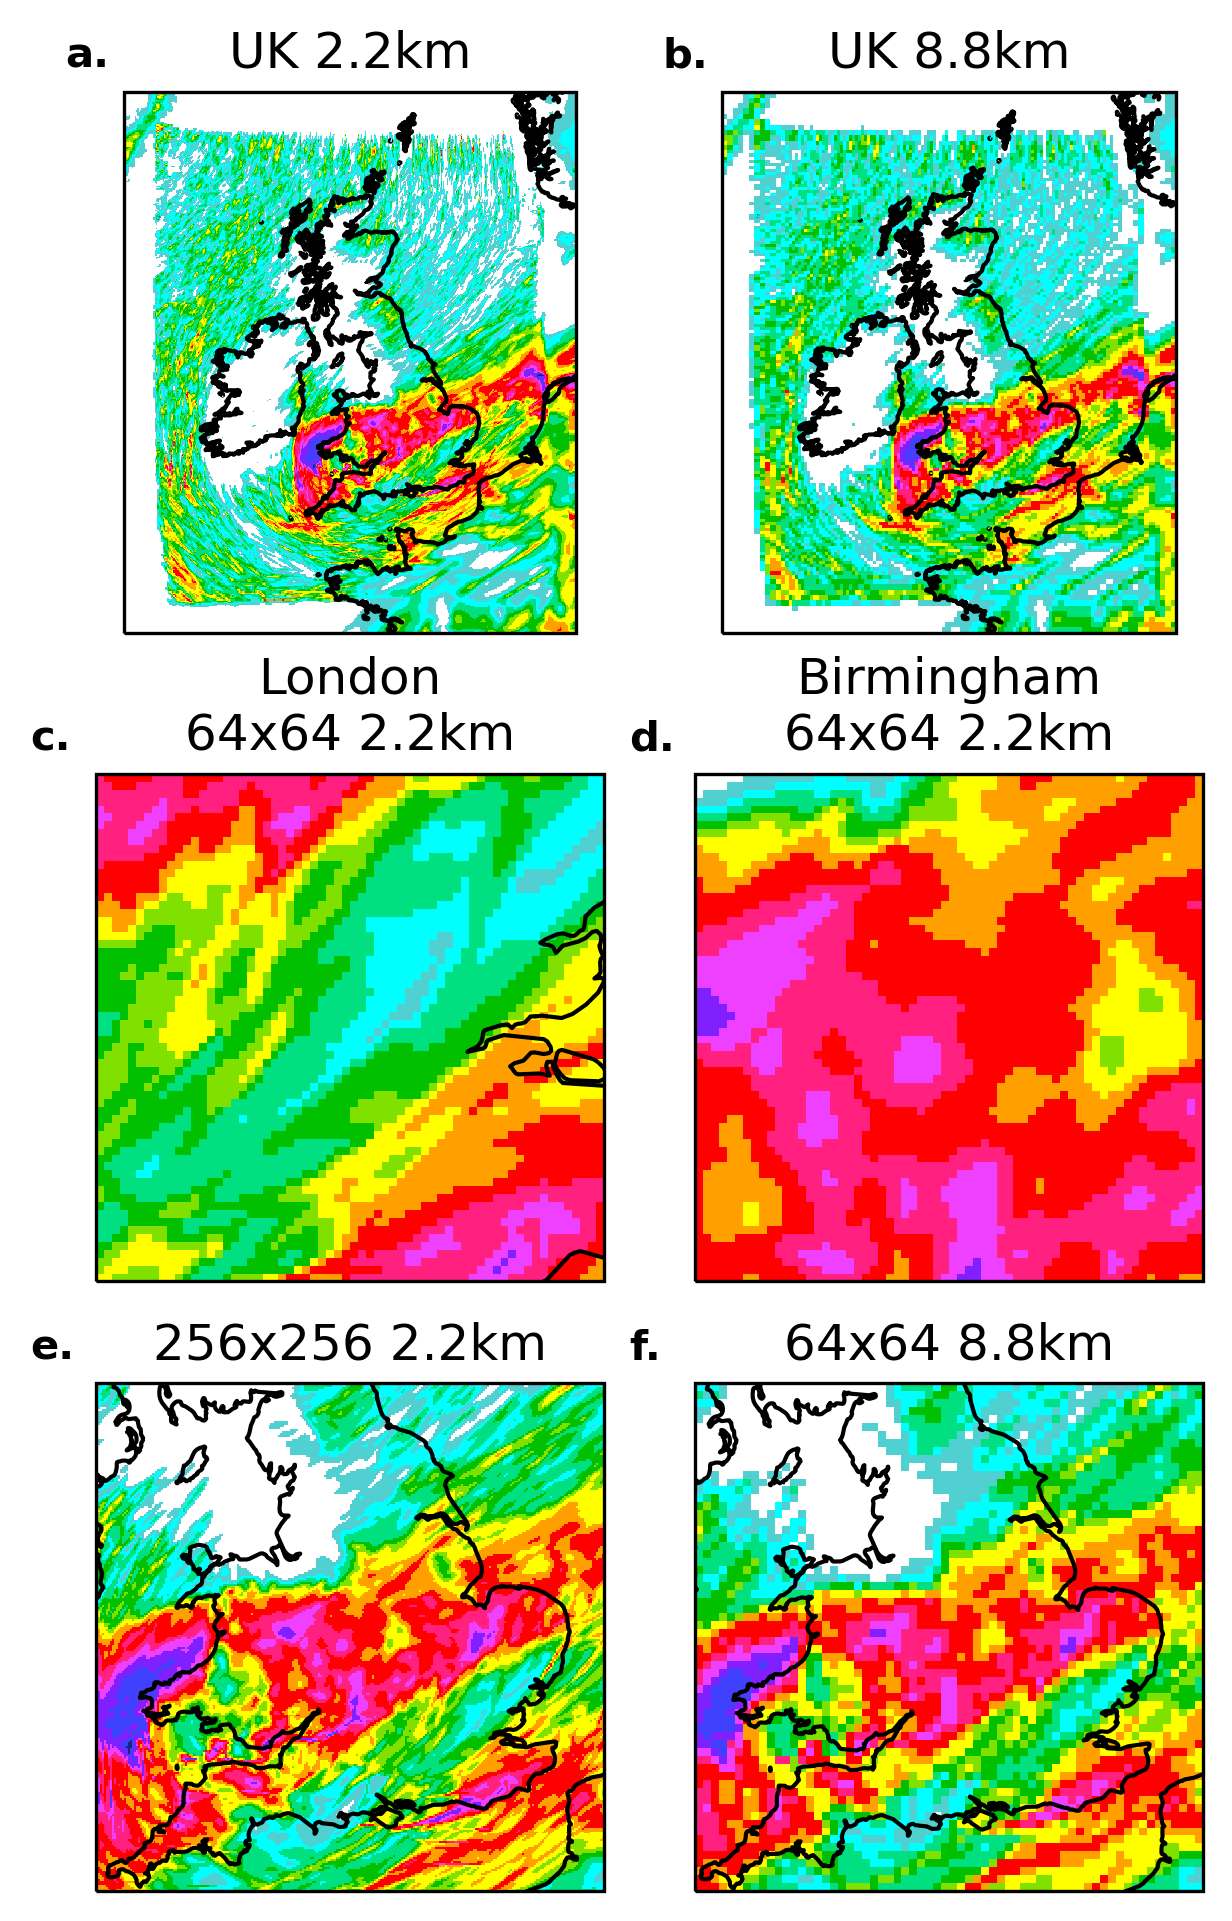

In [ ]:
fig, axs = plt.subplots(3, 2, subplot_kw=dict(projection=cp_model_rotated_pole), figsize=(4, 7), layout="compressed")

annotate_kwargs = dict(xy=(-0.13, 1.03),xycoords=("axes fraction", "axes fraction"),weight="bold",ha="left",va="bottom")


plot_map(ds["pr"], axs[0][0], title=f"UK 2.2km", style="pr")
plot_map(ds4x["pr"], axs[0][1], title=f"UK 8.8km", style="pr")

plot_map(SelectDomain(subdomain="london", size=64).run(ds)["pr"], axs[1][0], title=f"London\n64x64 2.2km", style="pr")
plot_map(SelectDomain(subdomain="birmingham", size=64).run(ds)["pr"], axs[1][1], title=f"Birmingham\n64x64 2.2km", style="pr")

plot_map(SelectDomain(subdomain="birmingham", size=64*4).run(ds)["pr"], axs[2][0], title=f"256x256 2.2km", style="pr")
plot_map(SelectDomain(subdomain="birmingham", size=64).run(ds4x)["pr"], axs[2][1], title=f"64x64 8.8km", style="pr")

for idx, ax in enumerate(axs.flat):
    ax.annotate(f"{string.ascii_lowercase[idx]}.", **annotate_kwargs)

plt.show()